# Applying Adaptive Optics with Turbulence
<font color='purple' size='4px' face='Georgia'>In this __`hcipy`__ implementation we will explore how to create atmospheric turbulence, pass the field through turbulence, then on deformable mirror and sensed by a webfront sensor and apply correction to deformable mirror through feedback to correct the aberration caused by atmospheric turbulence.</font>

First let's import HCIPy, and a few supporting libraries:

In [24]:
import sys
sys.path.insert(1, '../../hcipy')


from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

HCIPy implements a multi-layer atmospheric model. Each layer derives from `AtmosphericLayer`. This allows for multiple implementations of phase-screen calculation. One of the implemented methods is an infinite phase-screen extrusion method by Assemat et al. 2006. We first do some setup work.

Text(0.5, 1.0, 'Circular Aperture')

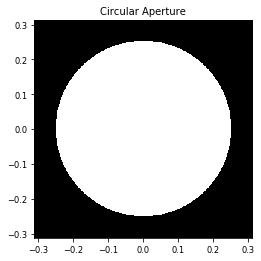

In [25]:
WAVELENGTH = 500e-9 # Wavelength
N = 512 # Number of Sample points along a side of the simulated window
D = 0.5 # Diameter of the pupil ?
pupil_grid = make_pupil_grid(N, D*1.25)

aperture = circular_aperture(D)
aperture_grid = aperture(pupil_grid)

imshow_field(aperture_grid, cmap='gray')
plt.title('Circular Aperture')


We can now construct the layer.

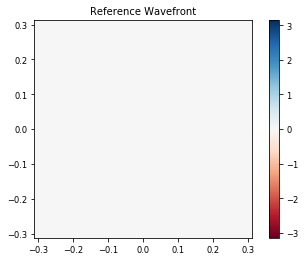

In [26]:
# Reference Flat Wavefront
wf_ref = Wavefront(aperture_grid, WAVELENGTH)
wf_ref.total_power = 1

imshow_field(wf_ref.phase*aperture_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu'); 
plt.title('Reference Wavefront')
plt.colorbar()


In [27]:
fried_parameter = 0.15 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)


'''
WHY IS THIS STEP SO SLOW. IT WILL BE REALLY DIFFICULT TO SIMULATE CHANGING TURBULENCE DUE TO WIND
AND APPLY DM CORRECTION IF THE CODE EXECUTION IS SO SLOW AT THIS STEP.

'''
# Make multi-layer atmosphere
layers = make_standard_atmospheric_layers(pupil_grid, outer_scale)
atmos = MultiLayerAtmosphere(layers, scintilation=True)

# Set the seeing parameter and reset
atmos.Cn_squared = Cn_squared
atmos.reset()


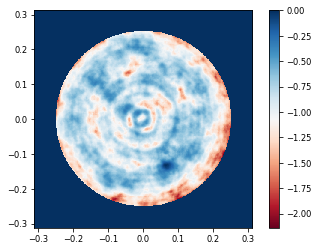

In [34]:
wf_atmos = atmos(wf_ref)

# Show scintillation field
#imshow_field(wf_atmos.intensity * aperture_grid, cmap='RdBu')
imshow_field(np.log10(wf_atmos.intensity/wf_atmos.intensity.max())*aperture_grid, cmap='RdBu')
plt.colorbar()
plt.show()


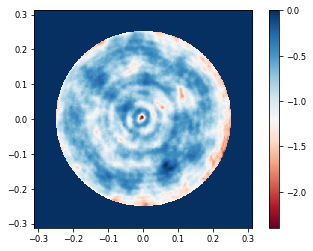

In [35]:
layers[0].t = 2.5 # SECONDS
layers[1].t = 2.5 # SECONDS
layers[3].t = 2.5 # SECONDS
wf_atmos = atmos(wf_ref)

'''
WHY IS THIS STEP SO SLOW. IT WILL BE REALLY DIFFICULT TO SIMULATE CHANGING TURBULENCE DUE TO WIND
AND APPLY DM CORRECTION IF THE CODE EXECUTION IS SO SLOW AT THIS STEP.

'''

atmos = MultiLayerAtmosphere(layers, scintilation=True)

# Show scintillation field
#imshow_field(wf_atmos.intensity * aperture_grid, cmap='RdBu')
imshow_field(np.log10(wf_atmos.intensity/wf_atmos.intensity.max())*aperture_grid, cmap='RdBu')
plt.colorbar()
plt.show()

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  


[-1.28e-05 -1.27e-05 -1.26e-05 ...  1.25e-05  1.26e-05  1.27e-05]


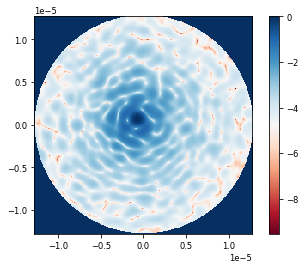

Min detector size is 2.5399999999999997e-05
RMS Wavefront Error of turbulent wavefron is 1.881176598073504


In [36]:
# Now we want to propagate to focal_plane
focal_grid = make_focal_grid(pupil_grid, 8, 16, wavelength=WAVELENGTH)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

wf_prop = prop(wf_atmos)


print(wf_prop.grid.x)

min_detector_size = np.abs(2*wf_prop.grid.x[-1])
detector = circular_aperture(min_detector_size)
detector_grid = detector(focal_grid)


#imshow_field(wf_prop.intensity*detector_grid, cmap='RdBu')
imshow_field(np.log10(wf_prop.intensity/wf_prop.intensity.max())*detector_grid, cmap='RdBu')

plt.colorbar()
plt.show()
print('Min detector size is {}'.format(min_detector_size))

## Calculate the wavefront's root mean sqaure error
wf_prop_rms = np.sqrt(np.mean(np.square(wf_prop.phase))-
                           
                           np.square(np.mean(wf_prop.phase)))

print('RMS Wavefront Error of turbulent wavefron is {}'.format(wf_prop_rms))

In [37]:
###############################################################

## Construct Shack Hartmann wavefront sesnor
(Taken from Wavefront_sensing_1.ipynb)


In [38]:
#SquareShackHartmannWavefrontSensorOptics(
#    input_grid,
#    f_number,
#    num_lenslets,
#    pupil_diameter,
#)

F_mla = 40. / 0.3 # F- NUMBER
N_mla = 5 # number of subapertures across the lenslet array

shwfs = SquareShackHartmannWavefrontSensorOptics(focal_grid, F_mla, N_mla, min_detector_size*1.05)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

## Deformable Mirror with which we need to calibrate our wavefront sensor
Our deformable mirror in this example is modeled as a Zernike freeform surface where each mode is a Zernike polynomial.

In [39]:
# DM slightly larger than the detector plane for better edge performance
actuator_grid = make_pupil_grid(10, min_detector_size*1.1)
sigma = min_detector_size/10.
gaussian_basis = make_gaussian_pokes(focal_grid, actuator_grid, sigma)
dm = DeformableMirror(gaussian_basis)

'''
IT IS NOT CLEAR BY num_modes is 100 here.

IS THERE A WAVE TO PLOT DM TO SEE WHERE ON DM ACTUATORS ARE LOCATED?
'''

num_modes = len(dm.influence_functions)
dm.actuators = np.zeros(num_modes)


The calibration process is as follows: we "poke" each mode of the DM with an equal positive and a negative amplitude successively, measure the shifts in the centroids of the microlens array images, and use these measurements to construct an interaction matrix.

In [40]:
# First set the amplitudes of all DM modes to zero, 
# and measure the reference position of the centroids

wf_dmref = Wavefront(detector_grid, WAVELENGTH)

'''

NOT SURE IF WAVEFRONT FOR CALIBRATIN DM SHOULD BE UNABERRATED REFERENCE WAVEFRONT

'''
img = shwfs.forward(wf_dmref).power
ref = shwfse.estimate([img]).ravel()
num_measurements = ref.shape[0]



# Now push on each mode individually and record the centroid shifts
amp = 1e-6
Intmat = []

for dm_mode in np.arange(num_modes):

    print("Now calibrating actuator {}/{}".format(dm_mode+1, num_modes))
    
    # Reset the list of slopes (average centroid shifts for each lenslet image)
    total_slopes = np.zeros((num_measurements,))

    # Push an actuator with a positive and negative amplitude
    for push in np.array([-amp, amp]):

        act_levels = np.zeros(num_modes)
        act_levels[dm_mode] = push

        dm.actuators = act_levels
        dm_wf = dm.forward(wf_dmref)
        sh_wf = shwfs.forward(dm_wf)
        sh_img = sh_wf.power # Save the image created at the wavefront sensor - to see the effect of poking modes
      #  imshow_field(sh_img)
      #  plt.colorbar()
      #  plt.show()
        #imsave_field("WFS_calibrate_" + str(dm_mode+1).zfill(2), sh_img)
        
        # Use the estimator to calculate the shifts in the centroids
        lenslet_centers = shwfse.estimate([sh_img])
        total_slopes += (lenslet_centers.ravel()- ref)/(2*push)
    Intmat.append(total_slopes)

dm.actuators = np.zeros(num_modes)

Intmat = ModeBasis(Intmat)

Now calibrating actuator 1/100
Now calibrating actuator 2/100
Now calibrating actuator 3/100
Now calibrating actuator 4/100
Now calibrating actuator 5/100
Now calibrating actuator 6/100
Now calibrating actuator 7/100
Now calibrating actuator 8/100
Now calibrating actuator 9/100
Now calibrating actuator 10/100
Now calibrating actuator 11/100
Now calibrating actuator 12/100
Now calibrating actuator 13/100
Now calibrating actuator 14/100
Now calibrating actuator 15/100
Now calibrating actuator 16/100
Now calibrating actuator 17/100
Now calibrating actuator 18/100
Now calibrating actuator 19/100
Now calibrating actuator 20/100
Now calibrating actuator 21/100
Now calibrating actuator 22/100
Now calibrating actuator 23/100
Now calibrating actuator 24/100
Now calibrating actuator 25/100
Now calibrating actuator 26/100
Now calibrating actuator 27/100
Now calibrating actuator 28/100
Now calibrating actuator 29/100
Now calibrating actuator 30/100
Now calibrating actuator 31/100
Now calibrating a

To reconstruct a wavefront, we need the control matrix which is obtained by inverting the interaction matrix. We use the singular value decomposition functionality offered to us by hcipy to obtain a pseudo-inverse of this matrix, cut off the singular values that are below a threshold.

In [41]:
control_mat = inverse_tikhonov(Intmat.transformation_matrix, rcond=1e-7)

With this information, we can reconstruct a wavefront using the SH-WFS centroid measurements it produces, on the modal basis of the DM. Let's see how well we can reconstruct the atmospheric turbulence phase screen from earlier.

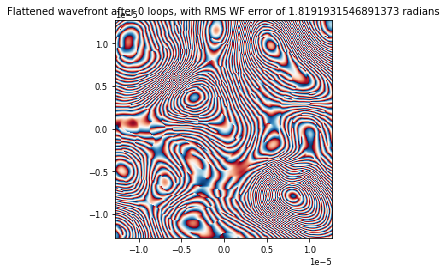

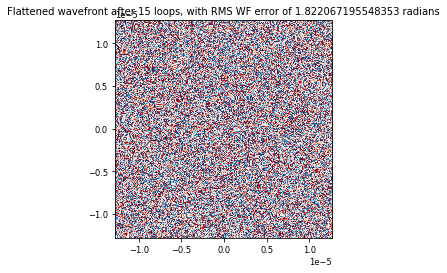

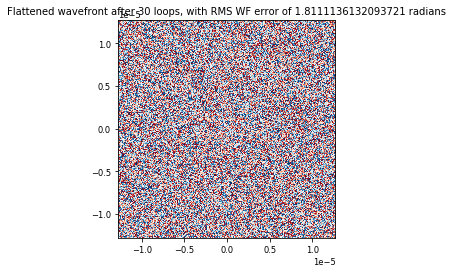

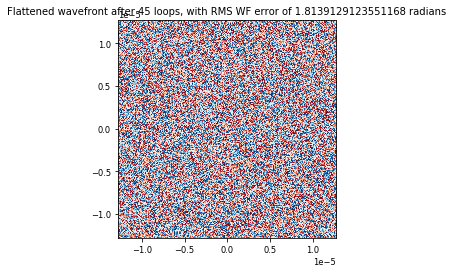

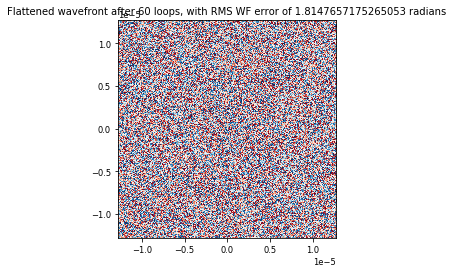

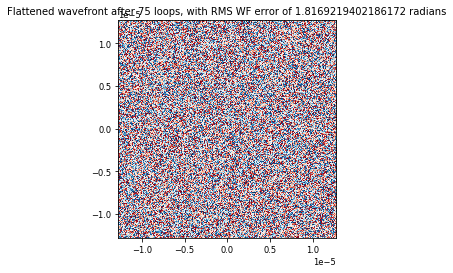

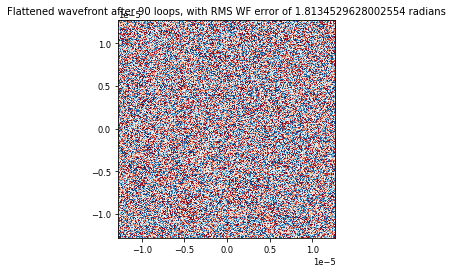

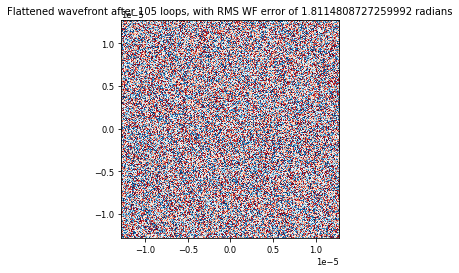

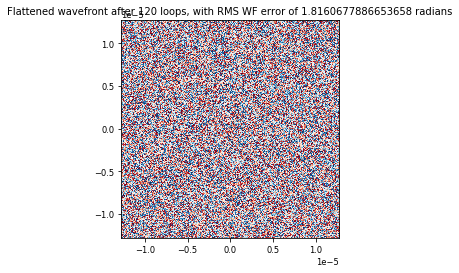

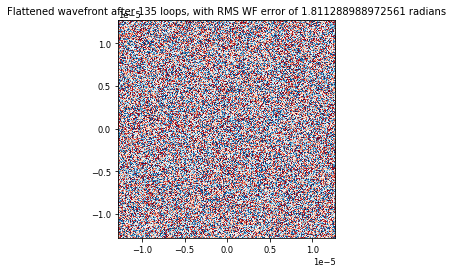

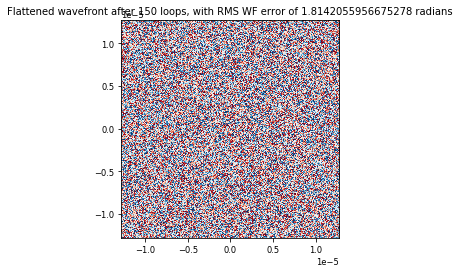

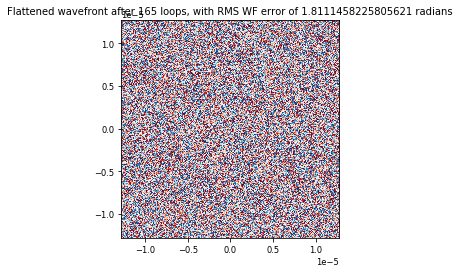

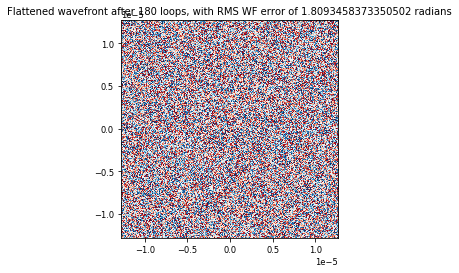

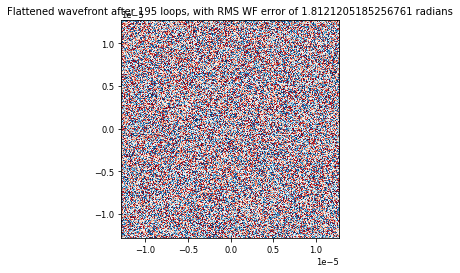

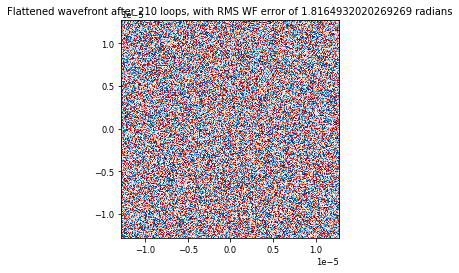

In [44]:
￼
AO_EXAMPLE_2
Last Checkpoint: 14 hours ago
(autosaved)
￼
￼Logout
Python 3 Kernel readyTrusted
File
Edit
View
Insert
Cell
Kernel
Help
￼￼￼￼￼￼￼￼Run￼￼￼￼￼
Applying Adaptive Optics with Turbulence
In this hcipy implementation we will explore how to create atmospheric turbulence, pass the field through turbulence, then on deformable mirror and sensed by a webfront sensor and apply correction to deformable mirror through feedback to correct the aberration caused by atmospheric turbulence.

First let's import HCIPy, and a few supporting libraries:

In [24]:
￼
import sys
sys.path.insert(1, '../../hcipy')
​
​
loops = 225 # Experiment with this to find the best number of loops to flatten the wavefront
gain = np.random.rand(num_modes) # Experiment with this to find a reasonable value

# Reset the DM modes to zero amplitude
dm.actuators = np.zeros(dm.actuators.shape)


# Assuming for the very first time, wavefront sensed by 
## WFS is abberrated one (as DM is flat in the beginning)
corrected_wf = wf_prop 


for loop in np.arange(loops):
    # Propagate the wavefront through the WFS optics
    
    ## Propagate the aberrated wavefront through dm
    dm_wf = dm.forward(corrected_wf)
    ## Propagate wavefron from dm to Wavefront sensor.
    sh_wf = shwfs.forward(dm_wf)
    sh_img = sh_wf.power

    
    ## Control Task
    # Estimate
    meas_vec = shwfse.estimate([sh_img])
    meas_vec = meas_vec.ravel()

    # Calculate the DM mode amplitudes to represent this change in wavefront
    change_in_actuators = control_mat.dot(meas_vec - ref)
    change_in_actuators -= change_in_actuators.mean() # note that we do this to remove piston errors that creep in
    dm.actuators -= gain * change_in_actuators
    
    ## Assuming DM is fast enough to act that wavefront has not
    ## changed much during DM adjusts its actuator based on WFS feedback
    
    '''
    WELL, THIS DOESN'T REALLY SEEM TO DO ANYTHING, AS CAN BE SEEN FROM EITHER INTENSITY PLOT OR PHASE PLOT BELOW.
    '''
    corrected_wf = dm.forward(corrected_wf)
    #wf_rms_error = np.sqrt(np.mean(np.square(wf_prop.phase)))
    ## Calculate the wavefront's root mean sqaure error
    wf_prop_rms = np.sqrt(np.mean(np.square(corrected_wf.phase))-
                           
                           np.square(np.mean(corrected_wf.phase)))

    if loop%15 == 0:
       # imshow_field(np.log10(corrected_wf.intensity/corrected_wf.intensity.max())*detector_grid, cmap='RdBu')
        imshow_field(corrected_wf.phase, cmap='RdBu')
        plt.title("Flattened wavefront after {0} loops, with RMS WF error of {1} radians".format(loop, wf_prop_rms))
        plt.draw()
        plt.pause(0.01)